In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.applications import EfficientNetB4
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Répertoires d'images
train_dir = "/kaggle/input/ibv3-mamograph/train"
test_dir = "/kaggle/input/ibv3-mamograph/test"
val_dir = "/kaggle/input/ibv3-mamograph/valid"

img_size = 224

# Chargement des images
def load_images_labels(directory):
    images = []
    labels = []
    label_map = {'Benign': 0, 'Malignant': 1}
    print(f"Chargement des images depuis : {directory}")
    for label in label_map:
        path = os.path.join(directory, label)
        print(f"  → Classe {label} : {len(os.listdir(path))} images")
        for file in os.listdir(path):
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                img_rgb = cv2.merge([img]*3)
                images.append(img_rgb)
                labels.append(label_map[label])
    return np.array(images) / 255.0, np.array(labels)

print("Étape 1 : Chargement des jeux de données...")
X_train, y_train = load_images_labels(train_dir)
X_test, y_test = load_images_labels(test_dir)
X_val, y_val = load_images_labels(val_dir)

print("Fusion des ensembles d'entraînement et de validation...")
X_total = np.concatenate((X_train, X_val), axis=0)
y_total = np.concatenate((y_train, y_val), axis=0)

X_train, X_val, y_train, y_val = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

print("Étape 2 : Construction du modèle EfficientNetB4...")
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

print("Résumé du modèle :")
model.summary()

print("Étape 3 : Compilation du modèle...")
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

print("Étape 4 : Préparation des données (augmentation)...")
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("Étape 5 : Calcul des poids de classe...")
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(f"Poids de classe : {class_weights}")

print("Étape 6 : Définition des callbacks...")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
]

print("Étape 7 : Lancement de l'entraînement...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks
)

print("Étape 8 : Sauvegarde du modèle entraîné...")
model.save("efficientnet_breast_cancer_model.h5")
print("✅ Modèle sauvegardé sous le nom : efficientnet_breast_cancer_model.h5")

print("Étape 9 : Évaluation sur les données de test...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Précision sur le test : {accuracy*100:.2f}%")

print("Étape 10 : Affichage des courbes d'apprentissage...")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Étape 11 : Prédictions sur les données de test...")
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Étape 12 : Matrice de confusion...")
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non Malin', 'Malin'], yticklabels=['Non Malin', 'Malin'])
plt.xlabel('Prédit')
plt.ylabel('Vérité')
plt.title('Matrice de confusion (%)')
plt.show()

print("Étape 13 : Rapport de classification...")
print(classification_report(y_test, y_pred, target_names=['Non Malin', 'Malin']))

print("Étape 14 : Affichage de quelques exemples de prédictions...")
plt.figure(figsize=(10,10))
for i in range(25):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred[idx][0]
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(f"Vérité : {true_label}, Prédit : {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("✅ Programme terminé avec succès.")

2025-05-27 22:28:57.174822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748384937.379393      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748384937.438697      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Étape 1 : Chargement des jeux de données...
Chargement des images depuis : /kaggle/input/ibv3-mamograph/train
  → Classe Benign : 1123 images
  → Classe Malignant : 2371 images
Chargement des images depuis : /kaggle/input/ibv3-mamograph/test
  → Classe Benign : 153 images
  → Classe Malignant : 284 images
Chargement des images depuis : /kaggle/input/ibv3-mamograph/valid
  → Classe Benign : 116 images
  → Classe Malignant : 321 images
Fusion des ensembles d'entraînement et de validation...
Étape 2 : Construction du modèle EfficientNetB4...


I0000 00:00:1748384975.479245      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Résumé du modèle :


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 18,134,112 (69.18 MB)

 Trainable params: 18,008,393 (68.70 MB)

 Non-trainable params: 125,719 (491.09 KB)

Étape 3 : Compilation du modèle...
Étape 4 : Préparation des données (augmentation)...
Étape 5 : Calcul des poids de classe...
Poids de classe : {0: 1.62564632885212, 1: 0.7220946256316031}
Étape 6 : Définition des callbacks...
Étape 7 : Lancement de l'entraînement...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1748385090.633942      77 service.cc:148] XLA service 0x794818002090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748385090.634830      77 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748385100.669389      77 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748385115.781916      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748385115.965534      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748385116.309411      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748385116.4977

52/99 ━━━━━━━━━━━━━━━━━━━━ 15s 326ms/step - accuracy: 0.5404 - loss: 0.8765

E0000 00:00:1748385195.606677      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748385195.791152      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748385196.106203      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748385196.305567      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748385196.802331      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

99/99 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.5466 - loss: 0.8676 - val_accuracy: 0.3456 - val_loss: 0.7835 - learning_rate: 1.0000e-04
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 342ms/step - accuracy: 0.6205 - loss: 0.7026 - val_accuracy: 0.5108 - val_loss: 0.6952 - learning_rate: 1.0000e-04
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 342ms/step - accuracy: 0.6995 - loss: 0.6161 - val_accuracy: 0.5515 - val_loss: 0.6830 - learning_rate: 1.0000e-04
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 340ms/step - accuracy: 0.7784 - loss: 0.4941 - val_accuracy: 0.6086 - val_loss: 0.6699 - learning_rate: 1.0000e-04
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 339ms/step - accuracy: 0.7944 - loss: 0.4340 - val_accuracy: 0.6544 - val_loss: 0.7090 - learning_rate: 1.0000e-04
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 341ms/step - accuracy: 0.8544 - loss: 0.3302 - val_accuracy: 0.7014 - val_loss: 0.6280 - learning_rate: 1.0000e-04
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 341ms/step - accuracy: 0.8739

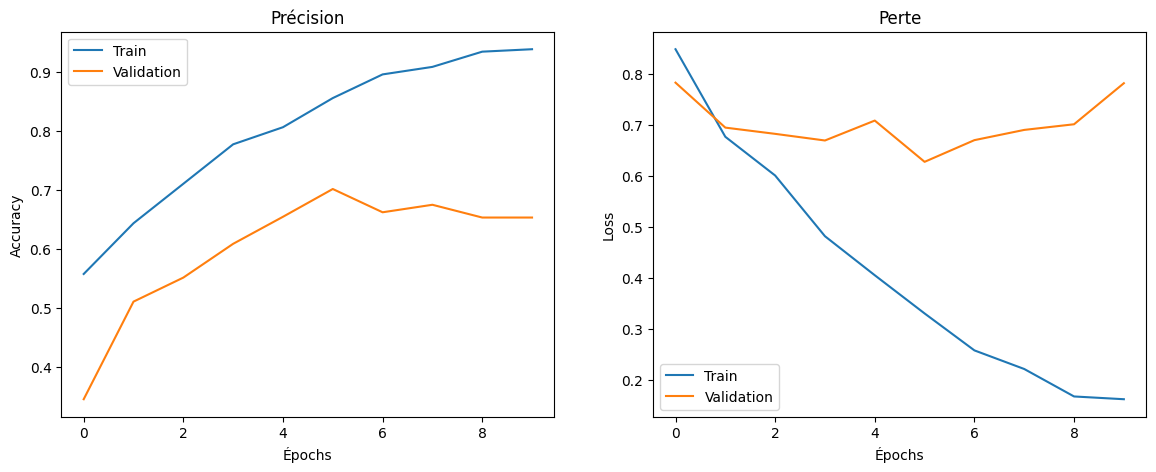

Étape 11 : Prédictions sur les données de test...
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 922ms/step
Étape 12 : Matrice de confusion...


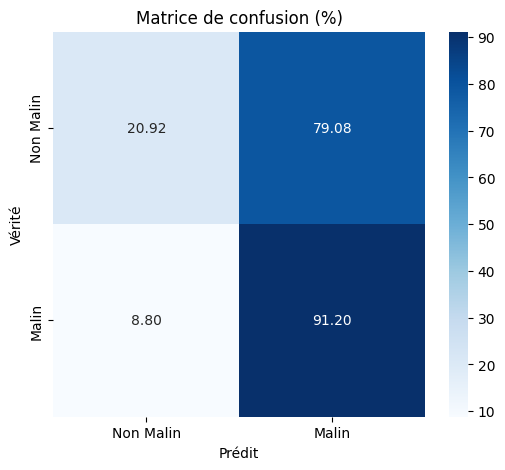

Étape 13 : Rapport de classification...
              precision    recall  f1-score   support

   Non Malin       0.56      0.21      0.30       153
       Malin       0.68      0.91      0.78       284

    accuracy                           0.67       437
   macro avg       0.62      0.56      0.54       437
weighted avg       0.64      0.67      0.61       437

Étape 14 : Affichage de quelques exemples de prédictions...


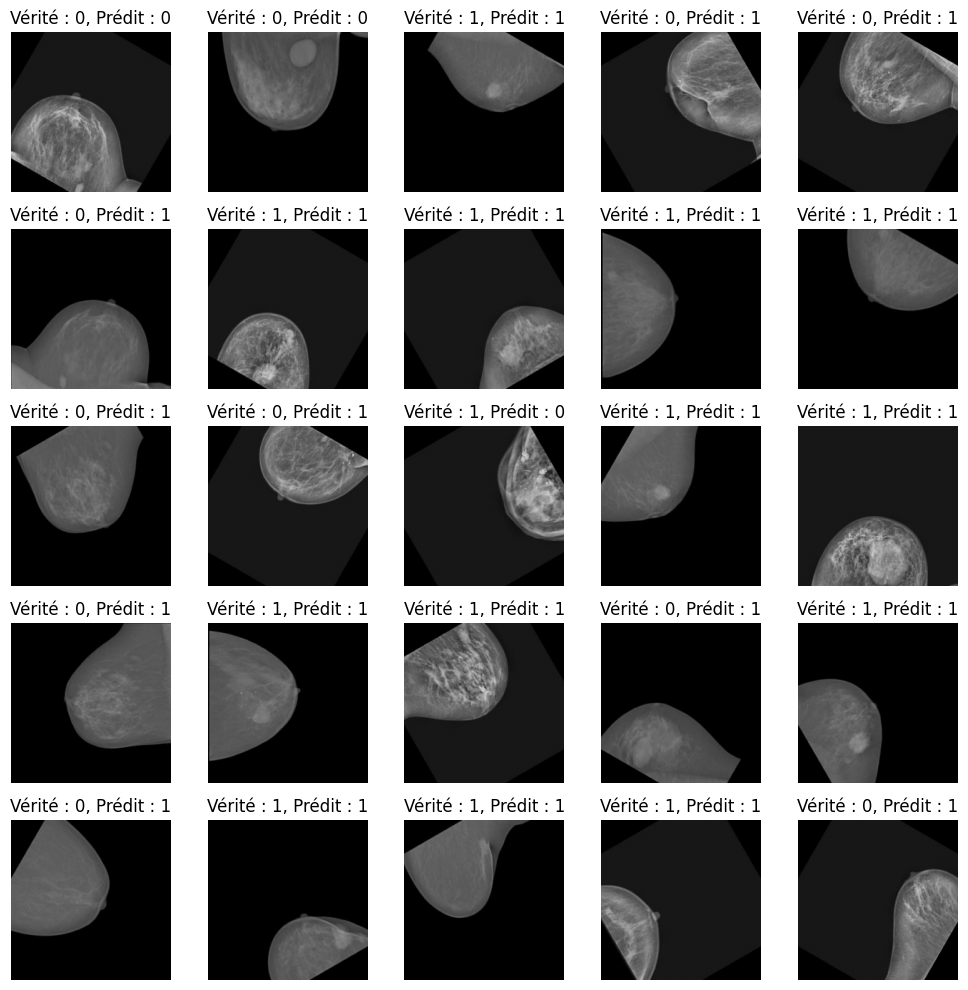

✅ Programme terminé avec succès.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.applications import EfficientNetB4
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Répertoires d'images
train_dir = "/kaggle/input/ibv3-mamograph/train"
test_dir = "/kaggle/input/ibv3-mamograph/test"
val_dir = "/kaggle/input/ibv3-mamograph/valid"

img_size = 224

# Chargement des images
def load_images_labels(directory):
    images = []
    labels = []
    label_map = {'Benign': 0, 'Malignant': 1}
    print(f"Chargement des images depuis : {directory}")
    for label in label_map:
        path = os.path.join(directory, label)
        print(f"  → Classe {label} : {len(os.listdir(path))} images")
        for file in os.listdir(path):
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                img_rgb = cv2.merge([img]*3)
                images.append(img_rgb)
                labels.append(label_map[label])
    return np.array(images) / 255.0, np.array(labels)

print("Étape 1 : Chargement des jeux de données...")
X_train, y_train = load_images_labels(train_dir)
X_test, y_test = load_images_labels(test_dir)
X_val, y_val = load_images_labels(val_dir)

print("Fusion des ensembles d'entraînement et de validation...")
X_total = np.concatenate((X_train, X_val), axis=0)
y_total = np.concatenate((y_train, y_val), axis=0)

X_train, X_val, y_train, y_val = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

print("Étape 2 : Construction du modèle EfficientNetB4...")
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

print("Résumé du modèle :")
model.summary()

print("Étape 3 : Compilation du modèle...")
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

print("Étape 4 : Préparation des données (augmentation)...")
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("Étape 5 : Calcul des poids de classe...")
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(f"Poids de classe : {class_weights}")

print("Étape 6 : Définition des callbacks...")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
]

print("Étape 7 : Lancement de l'entraînement...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks
)

print("Étape 8 : Sauvegarde du modèle entraîné...")
model.save("efficientnet_breast_cancer_model.h5")
print("✅ Modèle sauvegardé sous le nom : efficientnet_breast_cancer_model.h5")

print("Étape 9 : Évaluation sur les données de test...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Précision sur le test : {accuracy*100:.2f}%")

print("Étape 10 : Affichage des courbes d'apprentissage...")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Étape 11 : Prédictions sur les données de test...")
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Étape 12 : Matrice de confusion...")
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non Malin', 'Malin'], yticklabels=['Non Malin', 'Malin'])
plt.xlabel('Prédit')
plt.ylabel('Vérité')
plt.title('Matrice de confusion (%)')
plt.show()

print("Étape 13 : Rapport de classification...")
print(classification_report(y_test, y_pred, target_names=['Non Malin', 'Malin']))

print("Étape 14 : Affichage de quelques exemples de prédictions...")
plt.figure(figsize=(10,10))
for i in range(25):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred[idx][0]
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(f"Vérité : {true_label}, Prédit : {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("✅ Programme terminé avec succès.")

Étape 7 : Lancement de l'entraînement...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 358ms/step - accuracy: 0.8869 - loss: 0.2701 - val_accuracy: 0.7510 - val_loss: 0.5480 - learning_rate: 1.0000e-04
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 339ms/step - accuracy: 0.8965 - loss: 0.2483 - val_accuracy: 0.6773 - val_loss: 0.7229 - learning_rate: 1.0000e-04
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 343ms/step - accuracy: 0.9309 - loss: 0.1722 - val_accuracy: 0.8323 - val_loss: 0.3783 - learning_rate: 1.0000e-04
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 33s 334ms/step - accuracy: 0.9432 - loss: 0.1492 - val_accuracy: 0.7103 - val_loss: 0.6806 - learning_rate: 1.0000e-04
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 344ms/step - accuracy: 0.9556 - loss: 0.1081 - val_accuracy: 0.6531 - val_loss: 0.9703 - learning_rate: 1.0000e-04
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 346ms/step - accuracy: 0.9746 - loss: 0.0691 - val_accuracy: 0.7141 - val_loss: 0.7899 - learning_rate: 1.0000e-04
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 339ms/step - acc

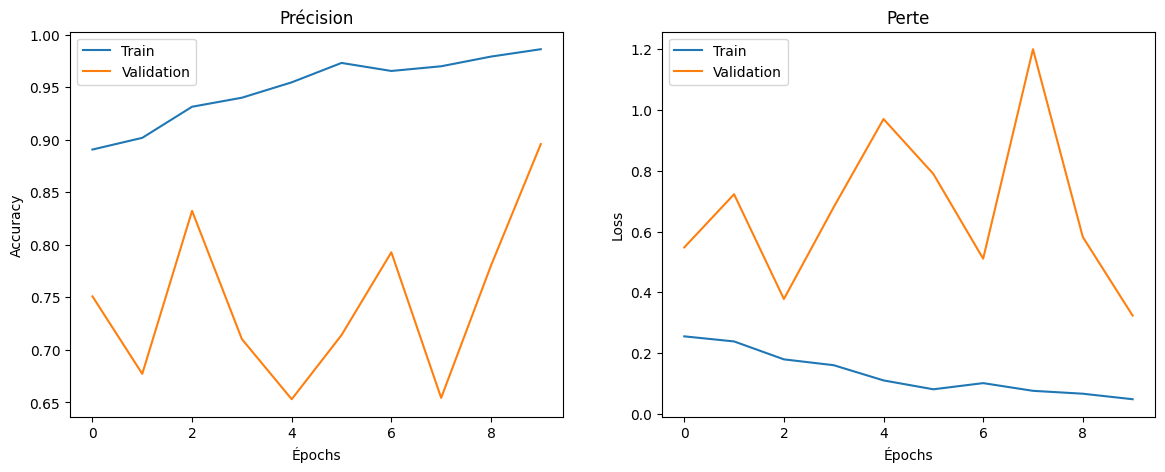

Étape 11 : Prédictions sur les données de test...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Étape 12 : Matrice de confusion...


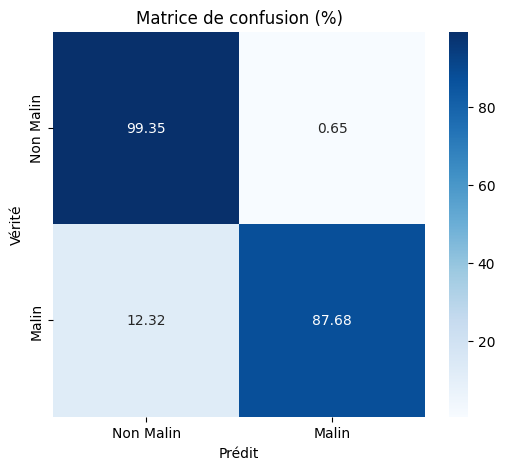

Étape 13 : Rapport de classification...
              precision    recall  f1-score   support

   Non Malin       0.81      0.99      0.89       153
       Malin       1.00      0.88      0.93       284

    accuracy                           0.92       437
   macro avg       0.90      0.94      0.91       437
weighted avg       0.93      0.92      0.92       437

Étape 14 : Affichage de quelques exemples de prédictions...


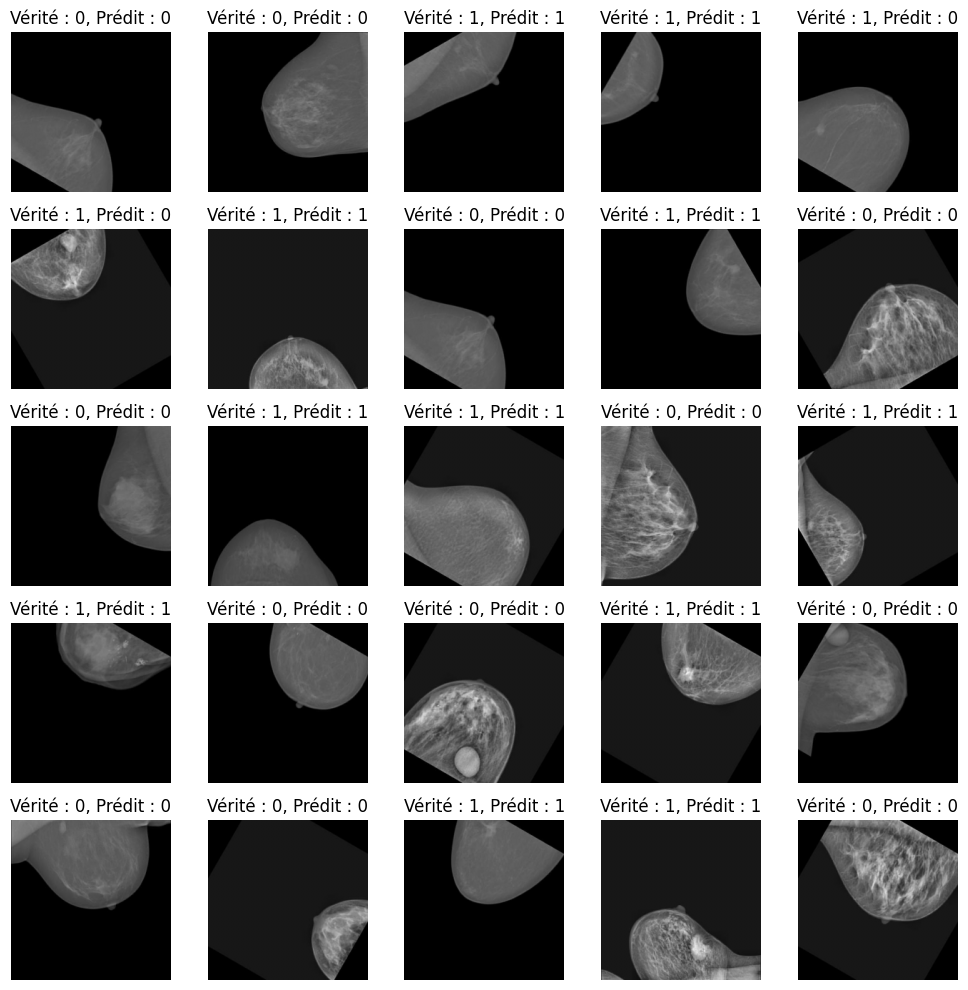

✅ Programme terminé avec succès.


In [2]:
print("Étape 7 : Lancement de l'entraînement...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks
)

print("Étape 8 : Sauvegarde du modèle entraîné...")
model.save("efficientnet_breast_cancer_model.h5")
print("✅ Modèle sauvegardé sous le nom : efficientnet_breast_cancer_model.h5")

print("Étape 9 : Évaluation sur les données de test...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Précision sur le test : {accuracy*100:.2f}%")

print("Étape 10 : Affichage des courbes d'apprentissage...")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Étape 11 : Prédictions sur les données de test...")
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Étape 12 : Matrice de confusion...")
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non Malin', 'Malin'], yticklabels=['Non Malin', 'Malin'])
plt.xlabel('Prédit')
plt.ylabel('Vérité')
plt.title('Matrice de confusion (%)')
plt.show()

print("Étape 13 : Rapport de classification...")
print(classification_report(y_test, y_pred, target_names=['Non Malin', 'Malin']))

print("Étape 14 : Affichage de quelques exemples de prédictions...")
plt.figure(figsize=(10,10))
for i in range(25):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred[idx][0]
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(f"Vérité : {true_label}, Prédit : {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("✅ Programme terminé avec succès.")